<div style=" background-color:  rgba(2,1,0,0.7);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 6 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Analysez les ventes d'une librairie avec R ou Python
</h2>
</div>

**Sommaire :**
 1. [Import des librairies et données nécessaires pour l'étude ](#1.-Import-des-librairies-et-données-nécessaires-pour-l'étude)
 2. [Observation et nettoyage des Dataframes ](#2.-Observation-et-nettoyage-des-Dataframes)
 3. [Jointure des dataframes ](#3.-Jointure-des-dataframes)
 4. [Différents indicateurs et graphiques autour du CA dont évolution dans le temps (par jour, mois et moyenne mobile):
](#3.-Différents-indicateurs-et-graphiques-autour-du-CA-dont-l'évolution-dans-le-temps:)
 5. [Evolution du chiffre d'affaires par catégorie](#4.-Evolution-du-chiffre-d'affaires-par-catégorie)
 5. [Analyse ciblée produits](#4.-Analyse-ciblée_produits)
 6. [Analyse ciblée clients](#4.-Analyse-ciblée_clients)
 7. [Analyse des correlations entre les variables
](#4.-Analyse-des-correlations-entre-les-variables
)

# Import des librairies et données nécessaires à l'étude:


In [243]:
# Importation des librairies de calcul nécessiares 
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Importation des librairies de visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

#Importation de chi2_contingency
from scipy.stats import chi2_contingency


# Importation des données 

customers_df = pd.read_csv('customers.csv')
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')

# Observation et nettoyage des Dataframes:


## transactions_df :

In [244]:
transactions_df.shape

(687534, 4)

In [245]:
transactions_df.head(3)

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580


In [246]:
transactions_df.info()
transactions_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687534 entries, 0 to 687533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     687534 non-null  object
 1   date        687534 non-null  object
 2   session_id  687534 non-null  object
 3   client_id   687534 non-null  object
dtypes: object(4)
memory usage: 21.0+ MB


,id_prod,date,session_id,client_id
count,687534,687534,687534,687534
unique,3265,687419,345505,8600
top,1_369,2021-10-06 21:29:59.752585,s_118668,c_1609
freq,2340,2,14,25586


Les données du fichier transactions contiennent 687534 transactions et 4 variables :

* "id_prod": le code des produits vendus déclarés comme étant un objet;
* "date": la date de la transaction n'est pas dans le bon format. Elle est déclarée comme étant un objet. Donc il faut convertir son type en un datetime.
* session_id : Id de chaque session.
* client_id : Id du client qui a effectué la transactions.

**Remarque :** Lors de l'exécution du ligne du code qui permet de modifier le type de la série 'date', une erreur l'empêche de s'exécuter. Nous allons imprimer l’exception exacte qui s’est produite.

In [247]:
try:
    transactions_df["date"] = pd.to_datetime(transactions_df["date"], yearfirst= True)
except Exception as error:
    # handle the exception
    print("An exception occurred:", error) # An exception occurred: format de la date

An exception occurred: time data "2021-10-02 24:04:58.422464" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 198325. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


L'échec de la conversion est du à la construction du date de la ligne 198325 qui contient la valeur 24 comme nombre d'heures
(normalement entre 0 et 23 h).

Voyons si d'autres lignes sont concernées.

In [248]:
transactions_df.loc[transactions_df['date'].str.contains(' 24:')]

,id_prod,date,session_id,client_id
198325,1_400,2021-10-02 24:04:58.422464,s_107311,c_2513
198326,1_601,2021-10-02 24:04:59.254020,s_107311,c_2513
198327,1_735,2021-10-02 24:04:59.422464,s_107311,c_2513
198328,1_351,2021-10-02 24:04:59.913108,s_107311,c_2513
198329,1_400,2021-10-02 24:06:02.588166,s_107205,c_5036
...,...,...,...,...
221108,1_445,2021-10-26 24:36:01.240212,s_105041,c_3949
221109,1_296,2021-10-26 24:36:21.240212,s_105041,c_3949
221820,1_45,2021-10-27 24:18:21.505552,s_98882,c_7656
221821,1_431,2021-10-27 24:20:46.744883,s_99594,c_8073


In [249]:
# pourcentage des 236 transactions parmi toutes les transactions (soit 687534 au total)
pourcentage = (236/687534)*100

print("les transactions dont la date n'est au bon format représentent", pourcentage , " % des transactions totales")

les transactions dont la date n'est au bon format représentent 0.03432557517155515  % des transactions totales


236 lignes correspondent à des dates contenant la valeur 24 comme nombre d'heures. Il est nécessaire soit de les supprimer ou bien les modifier  pour pouvoir convertir les dates de transaction dans le bon format. Ici j'ai opté pour les supprimer puisque cela représentent 0.034% des transactions. Donc les supprimer ne va pas fausser notre analyse.

In [250]:
# Suppression les lignes contenant ' 24:' comme nombre d'heures
transactions_df = (transactions_df.loc[~transactions_df['date'].str.contains(' 24:')].reset_index(drop=True))

# Convertir "date" dans le bon type
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [251]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687298 entries, 0 to 687297
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687298 non-null  object        
 1   date        687298 non-null  datetime64[ns]
 2   session_id  687298 non-null  object        
 3   client_id   687298 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 21.0+ MB


* Maintenant on a que **687298** (=687534-236) lignes, donc les 236 sont bien supprimés.
* Les date sont bien lues en datetime.

la dernière chose à voir concernant les dates des transactions c'est les différentes années  des transactions réalisées.

In [252]:
# les années des transactions
transactions_df['date'].dt.year.value_counts().sort_index()

date
2021    286435
2022    346380
2023     54483
Name: count, dtype: int64

In [253]:
# première et dernière vente enregistée

first_date = transactions_df['date'].min()
last_date = transactions_df['date'].max()
print(f'Date du premier enregistrement : {first_date}.\n'
      f'Date du dernier enregistrement : {last_date}.')
del first_date, last_date

Date du premier enregistrement : 2021-03-01 00:01:07.843138.
Date du dernier enregistrement : 2023-02-28 23:58:30.792755.


 Il y a des transactions sur trois années (2021,2022 et 2023 ). La première est en mars 2021 et la dernière en mois de février 2023.

On ragarde maintenant s'il ya des valeurs manquantes dans le dataframe.

In [254]:
# valeurs manquantes 
transactions_df.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

* Pas de valeurs manquantes.

## products_df :

In [255]:
products_df.shape

(3286, 3)

In [256]:
products_df.info()
products_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.1+ KB


,price,categ
count,3286.000000,3286.000000
mean,21.863597,0.370359
std,29.849786,0.615446
min,0.620000,0.000000
25%,6.990000,0.000000
50%,13.075000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


Les données du fichier products contient 3286 produits et 3 variables :

* id_prod : le code du produit (déclaré comme étant un objet) est une bonne clé pour Products_df puisqu'il y a 3286 valeurs uniques sur 3286 valeurs au total (.describe() plus haut)

* price : le prix du produit. Il est déclaré comme étant un float.
* categ : c'est la gatégorie du produit (c'est-à-dire, littérature, policiers, science- fiction...). Ici les catégories sont indiquées par des chiffres(codes).


Nous allons vérifier s'il ya des doublons pour le product_id et des valeurs manquantes.

In [257]:
#Test des doublons sur le product_id
test_doublons = products_df.duplicated(subset=['id_prod']).sum()

print(f'Il y a {test_doublons} doublons dans les codes produits.')

del test_doublons

#checker les valeurs manquantes
products_df.isna().sum()

Il y a 0 doublons dans les codes produits.


id_prod    0
price      0
categ      0
dtype: int64

 Pas de doublons ni de valeurs manquantes.

 **cohérence des données :**

* Pour le prix des produits : est-ce-que les prix sont tous positifs ?? 
* Quelles sont les différentes valeurs prises par catégorie ?? y-a-t'il des valeurs qui semblent incohérentes ?


In [258]:
def condition(x):
 return x<=0
lst = products_df['price']
sum(condition(x) for x in lst)

0

Donc, tous les prix sont bien positifs.

In [259]:
# les valeurs uniques prises par categorie
print(products_df['categ'].unique())

[0 1 2]


Donc, y a 3 catégories de livres 0, 1 et 2.

## customers_df :

In [260]:
customers_df.shape

(8621, 3)

In [261]:
customers_df.info()
customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


Les données du fichier customers contient 3286 lignes et 3 variables :

* client_id: client_id le code du client (déclaré comme étant un objet) est une bonne clé pour Customers_df puisqu'il y a 8621 valeurs uniques sur 8621 valeurs au total (.describe() plus haut)

* sex : le genre des clients. Il est déclaré comme étant un objet.
* birth : l'année de naissance des clients déclarée entier.

Dans un premier temps nous allons vérifier l'existance des doublons pour le client_id et l'existance des valeurs manquantes dans le dataframe ' customers_df'.

In [262]:
test_doublons = customers_df.duplicated(subset=['client_id']).sum()
print(f'Il y a {test_doublons} doublons dans les codes clients')

del test_doublons

Il y a 0 doublons dans les codes clients


In [263]:
customers_df.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

Donc pas de doublons ni valeurs manquantes.

**cohérence des données :**

* Le genre des clients est-il toujours soit "f", soit "m" ?
* Les années de naissances des clients sont-elles cohérentes ?


In [264]:
genders = customers_df['sex'].unique().tolist()
print(f'Les différentes valeurs de "sex" sont :{genders}.')
del genders

Les différentes valeurs de "sex" sont :['f', 'm'].


In [265]:
customers_df['birth'].sort_values().unique()

array([1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004],
      dtype=int64)

Les valeurs sont comprises entre 1929 et 2004 et il n'y a que des années composées de quatre chiffres.


La dernière chose a faire sur ce dataframe. On veut ajouter une colonne supplémentaire avec l\'âge du client pour facilter les taches après.


In [266]:
# Ajout d'une colonne "age" aux clients:
current_year = datetime.now().strftime('%Y')
customers_df["age"] = int(current_year) - customers_df["birth"]

# Verifications:
customers_df.info()
customers_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8621 entries, 0 to 8620
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
 3   age        8621 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 269.5+ KB


,birth,age
count,8621.000000,8621.000000
mean,1978.275606,45.724394
std,16.917958,16.917958
min,1929.000000,20.000000
25%,1966.000000,32.000000
50%,1979.000000,45.000000
75%,1992.000000,58.000000
max,2004.000000,95.000000


# Jointure des dataframes:


On souhaite conserver toutes les informations présentes dans transactions_df et les lier à celles présentes dans les deux autres dataframes. id_prod et client_id pourront être répétés plusieurs fois dans Transactions_df mais certains produits peuvent ne jamais avoir été vendus où certains clients peuvent ne jamais avoir effectué d'achats on souhaite pourtant conserver leurs informations. On fera une jointure "full outter". On s'attend donc à avoir vers la fin un dataframe avec  687298 lignes minimum (+ produits jamais vendus et clients non acheteurs)

In [267]:
# Premiere jointure:  ajoute les informations clients
Interm_df = pd.merge(transactions_df, customers_df, on="client_id", how="outer")
Interm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687319 entries, 0 to 687318
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687298 non-null  object        
 1   date        687298 non-null  datetime64[ns]
 2   session_id  687298 non-null  object        
 3   client_id   687319 non-null  object        
 4   sex         687319 non-null  object        
 5   birth       687319 non-null  int64         
 6   age         687319 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 36.7+ MB


La première jointure, de Customers_df sur Transactions_df donne le dataframe Interm_df avec **687319** lignes.
Donc, le nombre de lignes est bon puisque df_transactions avait 687298 enregistrements après suppression des incohérences et customers 8621 lignes.

In [268]:
# Seconde jointure: Ajoute les informations produits
df_final = pd.merge(Interm_df, products_df, on="id_prod", how="outer")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687340 entries, 0 to 687339
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687319 non-null  object        
 1   date        687298 non-null  datetime64[ns]
 2   session_id  687298 non-null  object        
 3   client_id   687319 non-null  object        
 4   sex         687319 non-null  object        
 5   birth       687319 non-null  float64       
 6   age         687319 non-null  float64       
 7   price       687319 non-null  float64       
 8   categ       687319 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 47.2+ MB


La seconde jointure, de Products_df sur Interm_df donne le dataframe df_final avec **687340** lignes. Donc le nombre de lignes est bon et les jointures sont correctement déroulées.

In [269]:
df_final.head(3)

,id_prod,date,session_id,client_id,sex,birth,age,price,categ
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,f,1967.0,57.0,11.99,0.0
1,0_1259,2022-10-01 00:01:07.843138,s_275943,c_329,f,1967.0,57.0,11.99,0.0
2,0_1259,2022-12-01 00:01:07.843138,s_305291,c_329,f,1967.0,57.0,11.99,0.0


In [270]:
df_final.isna().sum()

id_prod       21
date          42
session_id    42
client_id     21
sex           21
birth         21
age           21
price         21
categ         21
dtype: int64

Le nombre de NaN est très important :
* On a 21 clients qui n'ont pas fait d'achat sur notre site.
* On a également 21 produits qui ne se sont jamais vendus.
* Les variables 'price' et 'categ' affichent un même nombre de valeurs manquantes, 21 enregistrements n'ont ni prix, ni catégorie mais c'est tout à fait normal de les avoir puisque on a fait une jointure 'outer'.


In [271]:
# Enregistrements sans prix ni catégorie
df_final[(df_final['price'].isnull()) & (df_final['categ'].isnull())] 


,id_prod,date,session_id,client_id,sex,birth,age,price,categ
687298,NaN,NaT,NaN,c_8253,f,2001.0,23.0,NaN,NaN
687299,NaN,NaT,NaN,c_3789,f,1997.0,27.0,NaN,NaN
687300,NaN,NaT,NaN,c_4406,f,1998.0,26.0,NaN,NaN
687301,NaN,NaT,NaN,c_2706,f,1967.0,57.0,NaN,NaN
687302,NaN,NaT,NaN,c_3443,m,1959.0,65.0,NaN,NaN
687303,NaN,NaT,NaN,c_4447,m,1956.0,68.0,NaN,NaN
687304,NaN,NaT,NaN,c_3017,f,1992.0,32.0,NaN,NaN
687305,NaN,NaT,NaN,c_4086,f,1992.0,32.0,NaN,NaN
687306,NaN,NaT,NaN,c_6930,m,2004.0,20.0,NaN,NaN
687307,NaN,NaT,NaN,c_4358,m,1999.0,25.0,NaN,NaN


Pour faciliter les calculs par la suite on crée un dataframe 'ventes_df' ne contenant que les ventes (donc pas de clients non acheteurs ou de produits non vendus). Au  même temps on garde le dataframe initial ( df_final) qui contient tout les produits et clients si besoin après pour d'autres analyses.

In [272]:
# Creation de Ventes_df:
ventes_df = df_final.dropna()
ventes_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 687298 entries, 0 to 687297
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     687298 non-null  object        
 1   date        687298 non-null  datetime64[ns]
 2   session_id  687298 non-null  object        
 3   client_id   687298 non-null  object        
 4   sex         687298 non-null  object        
 5   birth       687298 non-null  float64       
 6   age         687298 non-null  float64       
 7   price       687298 non-null  float64       
 8   categ       687298 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 52.4+ MB


checker que les valeurs manquantes sont disparues.

In [273]:
# checker que les valeurs manquantes sont bien disparues
ventes_df.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
age           0
price         0
categ         0
dtype: int64

In [274]:
ventes_df.describe(include="all")

,id_prod,date,session_id,client_id,sex,birth,age,price,categ
count,687298,687298,687298,687298,687298,687298.000000,687298.000000,687298.000000,687298.000000
unique,3265,NaN,345387,8600,2,NaN,NaN,NaN,NaN
top,1_369,NaN,s_118668,c_1609,m,NaN,NaN,NaN,NaN
freq,2338,NaN,14,25586,344734,NaN,NaN,NaN,NaN
mean,NaN,2022-03-01 22:34:32.406761216,NaN,NaN,NaN,1977.817663,46.182337,17.492665,0.448600
min,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,1929.000000,20.000000,0.620000,0.000000
25%,NaN,2021-09-10 09:23:21.452309760,NaN,NaN,NaN,1970.000000,37.000000,8.990000,0.000000
50%,NaN,2022-02-27 09:25:30.888587008,NaN,NaN,NaN,1980.000000,44.000000,13.990000,0.000000
75%,NaN,2022-08-28 23:26:51.933032448,NaN,NaN,NaN,1987.000000,54.000000,19.080000,1.000000
max,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,2004.000000,95.000000,300.000000,2.000000


Le client c_1609 a acheté à lui seul 25488 livres. Donc, on cherche à vérifier qu'il ne s'agit pas d'une erreur.



**Focus sur le client c_1609 qui a plus de 25000 achats**

In [275]:
# Selection du client c_1609 dans la table transaction
ventes_df[ventes_df['client_id'] == 'c_1609'].sort_values(by="date")

,id_prod,date,session_id,client_id,sex,birth,age,price,categ
170798,0_1304,2021-03-01 00:07:04.371179,s_7,c_1609,m,1980.0,44.0,5.86,0.0
267945,0_1159,2021-03-01 00:11:57.832228,s_7,c_1609,m,1980.0,44.0,7.99,0.0
268430,0_1425,2021-03-01 01:56:41.944044,s_46,c_1609,m,1980.0,44.0,12.99,0.0
78173,0_1469,2021-03-01 02:12:21.294004,s_53,c_1609,m,1980.0,44.0,14.99,0.0
166488,1_406,2021-03-01 02:41:13.649521,s_63,c_1609,m,1980.0,44.0,24.81,1.0
...,...,...,...,...,...,...,...,...,...
599261,1_735,2023-02-28 21:42:40.632842,s_348401,c_1609,m,1980.0,44.0,22.99,1.0
374633,0_1594,2023-02-28 22:04:16.664518,s_348409,c_1609,m,1980.0,44.0,3.33,0.0
109891,0_1940,2023-02-28 22:09:50.559145,s_348409,c_1609,m,1980.0,44.0,18.31,0.0
367375,0_1002,2023-02-28 22:27:00.464046,s_348409,c_1609,m,1980.0,44.0,8.31,0.0


In [276]:
# Selection du client c_1609 dans la table customer afin de vérifier ses données. 
customers_df[customers_df['client_id'] == 'c_1609']

,client_id,sex,birth,age
3641,c_1609,m,1980,44


In [277]:
# je procède à un classement du nombre d'achat par client pour vérifier si d'autres clients ont un profil d'achat similaire
ventes_df.groupby(['client_id']).size().sort_values(ascending = False).head(15)

client_id
c_1609    25586
c_6714     9199
c_3454     6793
c_4958     5222
c_2140      405
c_3263      403
c_2595      398
c_2077      386
c_1637      384
c_7421      381
c_1422      379
c_8510      377
c_760       377
c_8026      376
c_8556      374
dtype: int64

<Axes: >

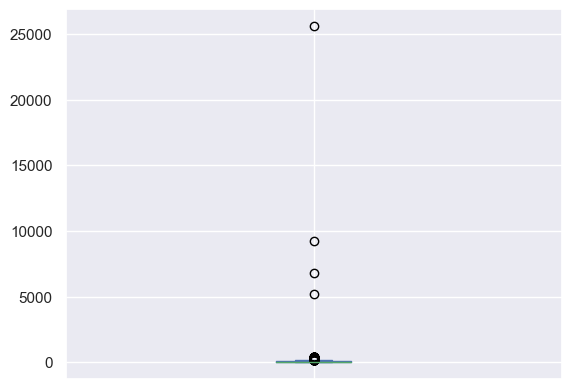

In [278]:
# Je cherche à visualiser les outliers avec un box plot
ventes_df.groupby(['client_id']).size().sort_values(ascending = False).plot.box()

In [279]:
# Je selectionne spécifiquement le client c_1609
client_c_1609 = ventes_df[ventes_df['client_id'] == 'c_1609'].sort_values(by="date")

In [280]:
# j'applique la méthode d'aggrégation groupby afin d'obtenir le classement des produits acheté par le client
client_c_1609.groupby(['id_prod']).size().sort_values(ascending = False)

id_prod
0_1438    95
0_1360    79
0_1334    78
0_1424    75
0_1411    73
          ..
0_597      1
0_596      1
0_595      1
0_594      1
2_46       1
Length: 1922, dtype: int64

**Conclusion :**
* Le client c_1609 est peut être  un revendeurs les livres?
* A noter 4 clients dont le nombre d'achats est supérieur à 5000 livres.

Maintenant, pour facliter la minpulation dates dans notre analyse, on récupère pour chaque vente l'année, le mois et le jour.

In [281]:
# Faciliter la manipulation des dates:
ventes_df["year"] = ventes_df["date"].dt.year
ventes_df["month"] = ventes_df["date"].dt.month
ventes_df["day"] = ventes_df["date"].dt.day

C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\1735832155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df["year"] = ventes_df["date"].dt.year
C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\1735832155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df["month"] = ventes_df["date"].dt.month
C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\1735832155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Donc, à ce stade on peut passer à la partie d'analyse des indicateurs de vente.

# Différents indicateurs et graphiques autour du CA dont évolution dans le temps:



##  Analyse du chiffre d'affaire (CA) dans le temps


Pour commencer, on calcule quelques chiffres intéressants pour notre analyse :
* CA total
* CA annuel
* CA moyen annuel
* Nombre de ventes annuel

Puis,  on cherche à montrer comment le CA évolue au fil du temps : son évolution par jour et par mois:
* Evolution du CA journalier et moyenne mobile
* Evolution mensuelle du CA et moyenne mobile


**Chiffre d\'affaires total :**

In [282]:
# Le chiffre d'affaires total 
ca_total = round(ventes_df['price'].sum(),1)

# Les ventes total
ventes_total = ventes_df['session_id'].value_counts().sum()

print(f'le chiffre d\'affaires total réalisé depuis l\'ouverture du  site de notre librairie est de {ca_total} € pour un total de {ventes_total} transactions.')

le chiffre d'affaires total réalisé depuis l'ouverture du  site de notre librairie est de 12022673.6 € pour un total de 687298 transactions.


**CA moyen et CA total par année :**

On cherche à comparer le CA total par an au CA moyen


In [283]:
# pivot table du CA total par an
ca_annuel= ventes_df.pivot_table(values='price',index='year', aggfunc=sum).reset_index()
ca_annuel.rename(columns={'price': 'CA'})
print("Chiffres d'affaires annuels:\n", ca_annuel)
# Nombre de ventes annuel:
ventes_annuelles = ventes_df.groupby(["year"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels:
    year       price
0  2021  4939771.43
1  2022  6108681.81
2  2023   974220.31
Nombre de ventes annuelles:
 year
2021    286435
2022    346380
2023     54483
Name: session_id, dtype: int64


In [284]:
# Group by CA total par an
CA_annuel = ventes_df['price'].groupby(ventes_df['year'])
# CA moyen par an
print("Le chiffre d'affaires moyen par année : ")
CA_annuel.mean()


Le chiffre d'affaires moyen par année : 


year
2021    17.245698
2022    17.635781
2023    17.881180
Name: price, dtype: float64

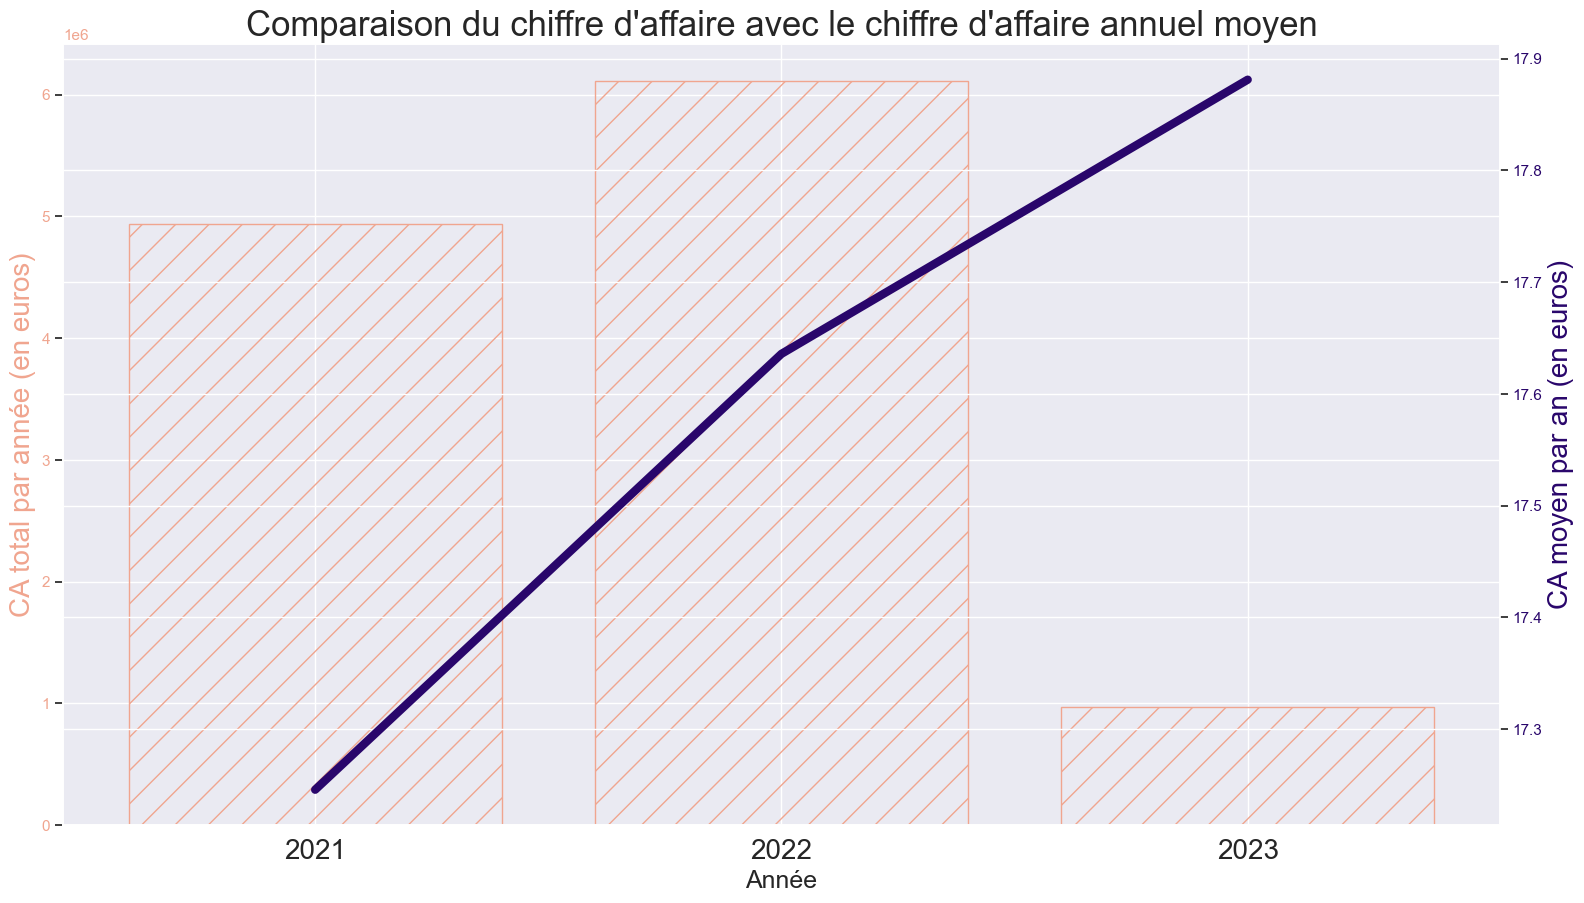

<Figure size 640x480 with 0 Axes>

In [285]:
# Représentation graphique
# serie du CA par an, pour l'axe y du graphique 
serie_ca=ca_annuel['price']
# serie des année, pour l'axe x du graphique 
serie_year=ca_annuel['year']
fig,ax1 = plt.subplots(figsize=(16,9))

color = '#F0A58F'
ax1.set_xlabel('Année', fontsize=18)
ax1.set_ylabel('CA total par année (en euros)', color=color, fontsize = 20)
ax1.bar(serie_year,serie_ca, edgecolor="#F0A58F", hatch= "/",color="None" )
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(fontsize=20)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#29066B'
ax2.set_ylabel('CA moyen par an (en euros)', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.plot(ventes_df.pivot_table(values='price',index='year'), color="#29066B", linestyle = 'solid', linewidth=6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Comparaison du chiffre d'affaire avec le chiffre d'affaire annuel moyen", fontsize=25)
plt.show()
plt.savefig("ComparaisonCaMoyen.png")

**Conclusion :**
* 2022 est donc notre meilleure année en matière de chiffre d'affaires et de nombre de ventes jusqu'à maintenant.
* Alors que l'année 2023 connait le CA total le plus faible, c'est également l'année où le CA moyen est le plus élevé.
* Cependant les données de 2023 ne sont pas complètes, la dernière session datant du 28 février à 23h58. Il faudrait donc pousser encore l'analyse et suivre à la fois l'évolution journalière et mensuelle du chiffre d'affaires pour obtenir une image complète de la performance commerciale de l'entreprise au cours de la future période.

**Evolution du chiffre d\'affaires par jour et moyenne mobile:**


In [286]:
# Je crée J, le dataframe qui aggrège les CA par jour 
ca_journalier = ventes_df.groupby(["year","month","day"])["price"].sum()
#ca_journalier
# Je crée le dataframe des moyennes mobiles MB_J
MB_J= ca_journalier.rolling(14).mean()
MB_J

year  month  day
2021  3      1               NaN
             2               NaN
             3               NaN
             4               NaN
             5               NaN
                        ...     
2023  2      24     16321.421429
             25     16258.920714
             26     16169.054286
             27     16470.637857
             28     16571.725000
Name: price, Length: 730, dtype: float64

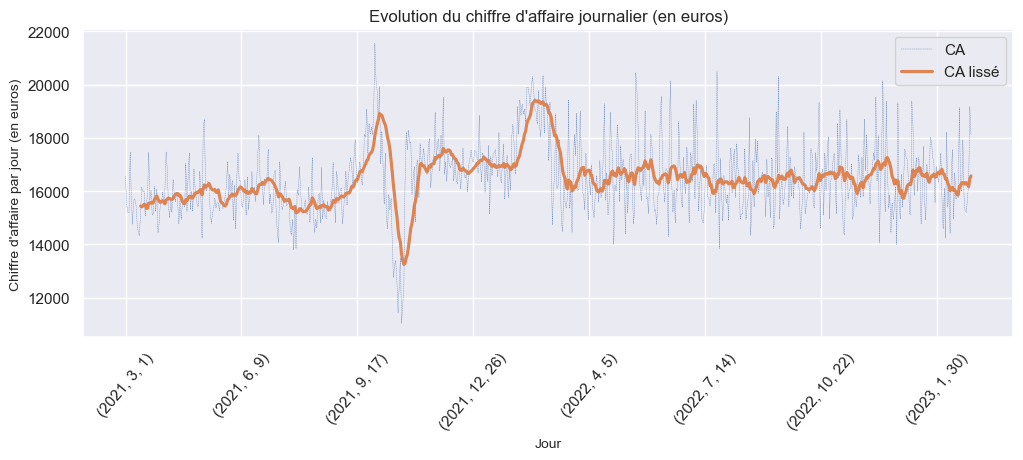

In [287]:
#Représentation graphique:

ca_journalier.plot(kind='line',figsize=(12,4), linestyle = 'dashed', linewidth=0.25, label = 'CA')
#rajout de la courbe des moyenne mobile à 30 jour pour lisser le CA
MB_J.plot(kind='line', linestyle="solid", linewidth=2.25, label='CA lissé')
plt.xlabel('Jour', fontsize = 10)
plt.ylabel("Chiffre d'affaire par jour (en euros)",fontsize = 10)
plt.title("Evolution du chiffre d'affaire journalier (en euros)")
plt.xticks(rotation = 50)
plt.legend()
plt.savefig("graphiqueEvolitionCa.png")

**Conclusion :**
* Une chute du CA durant le mois d'octobre 2021
* Nécessaire investigation sur le mois d'octobre


**Focus sur le mois d'octobre 2021 :**


* On cherche à comprendre ce qui aurait pu expliquer cette chute du CA au mois d'octobre 2021
* On sélectionne la période du mois d'octobre

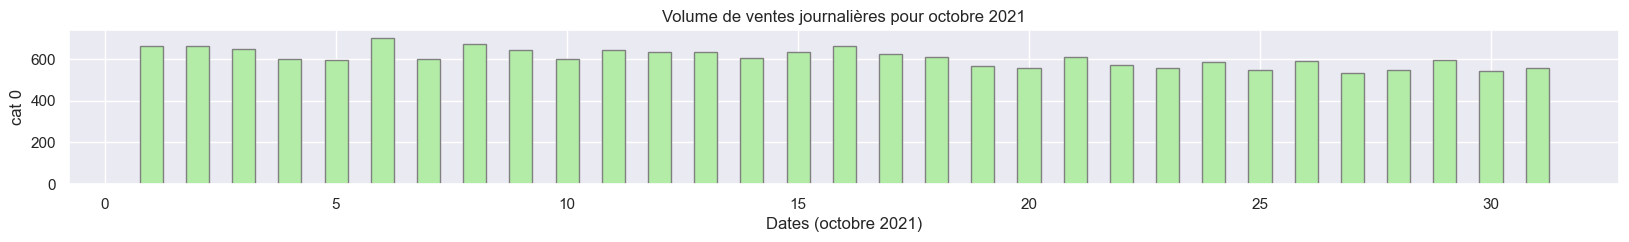

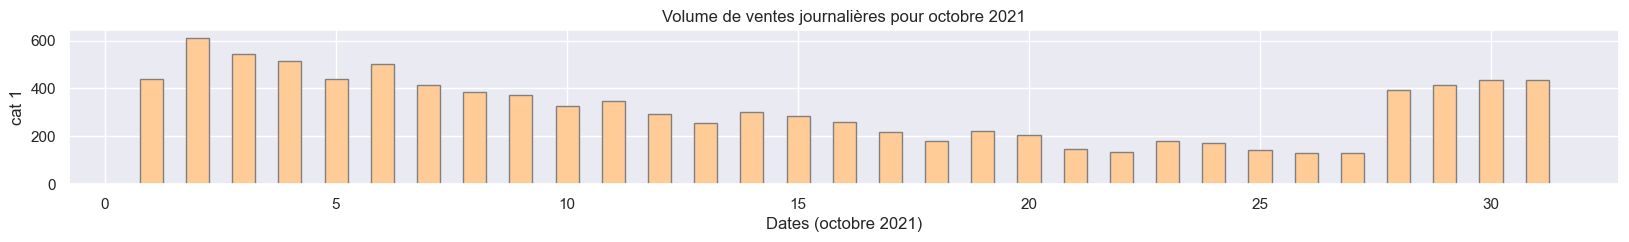

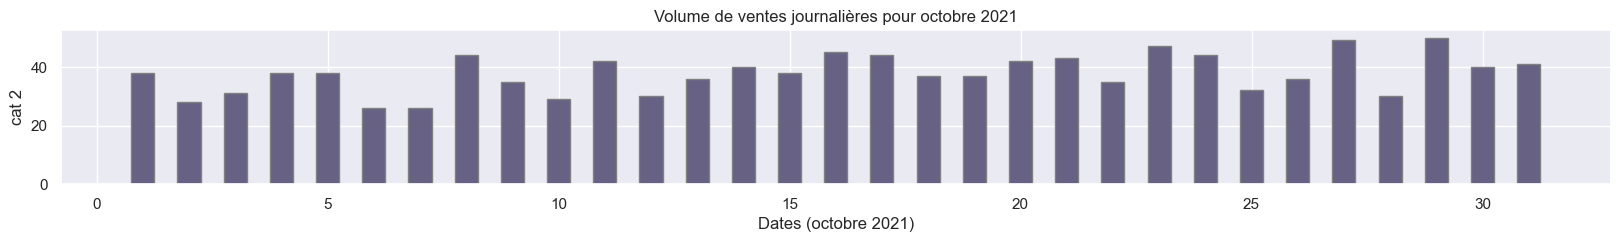

In [288]:
# On se penche en detail des catégories vendues en mois d'octobre 2021:
colors = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

Octobre_df = ventes_df.loc[(ventes_df["year"] == 2021) & (ventes_df["month"] == 10), ["day", "price","categ","client_id"]]
Octobre_df_categ = Octobre_df.groupby(["day","categ"]).agg({"price":["sum","count"]}).reset_index()
Octobre_df_categ.columns = ["day", "categ", "ca", "volume"]
Octobre_df_categ = pd.pivot_table(Octobre_df_categ, columns=["categ"], index=["day"]).reset_index()
Octobre_df_categ.columns = ["day", 'ca_0', 'ca_1', 'ca_2', 'vol_0', 'vol_1', 'vol_2']

color=colors
for i, cat in enumerate([0,1,2]):
    plt.figure(figsize=(44,2))
    plt.subplot(1,2,2)
    plt.bar(Octobre_df_categ["day"], Octobre_df_categ[f'vol_{cat}'], width=0.5, color=color[i],edgecolor = "grey", linewidth = 1)
    plt.xlabel("Dates (octobre 2021)")
    plt.ylabel(f'cat {cat}')
    plt.title("Volume de ventes journalières pour octobre 2021")
    plt.show()

* Les trois catégories sont vendues tout au long du mois d'octobre. Mais laquelle la plus vendue en octobre ???
*  La catégorie 1 dont le nombre de ventes a baissé puis est remonté peut certainement être l'une des causes de la baisse du chiffre d'affaires.

C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\2023108810.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar1 = sns.barplot(x = 'month', y = 'price', data = total, estimator = sum, ci = None, color = 'blue')
C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\2023108810.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar2 = sns.barplot(x='month', y = 'price', data = cat1, estimator = sum, ci = None, color ='green' )
C:\Users\hicha\AppData\Local\Temp\ipykernel_47596\2023108810.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar3 = sns.barplot(x='month', y = 'price', data = cat2, estimator = sum, ci = None, color ='red')


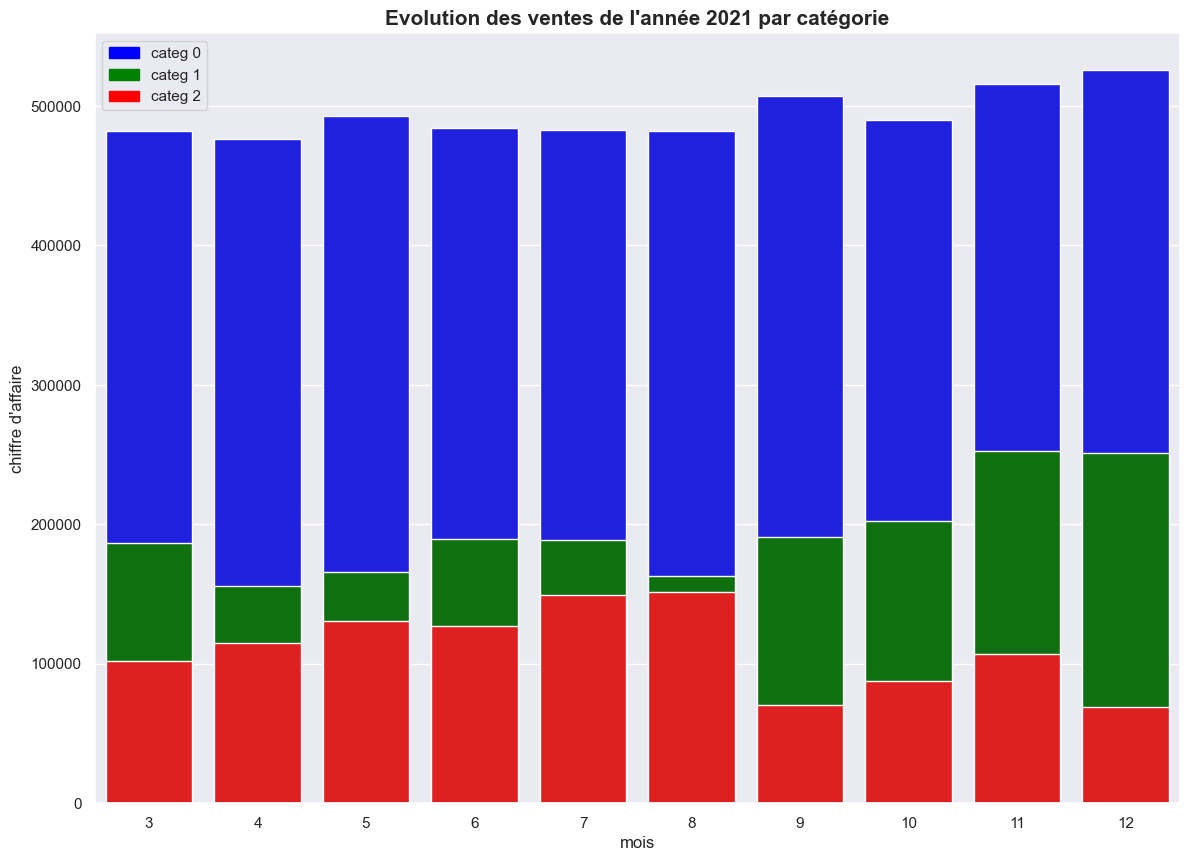

In [289]:
transaction_2021 = ventes_df.loc[ventes_df['year']== 2021,:]

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize = (14, 10))

total = transaction_2021.groupby('month')['price'].sum().reset_index()

bar1 = sns.barplot(x = 'month', y = 'price', data = total, estimator = sum, ci = None, color = 'blue')

#cat0 = transactions_2021.loc[transactions_2021['categ']== 0.0]
cat0 = transaction_2021[transaction_2021.categ==0]
cat1 = transaction_2021[transaction_2021.categ==1]
cat2 = transaction_2021[transaction_2021.categ==2]

bar2 = sns.barplot(x='month', y = 'price', data = cat1, estimator = sum, ci = None, color ='green' )
bar3 = sns.barplot(x='month', y = 'price', data = cat2, estimator = sum, ci = None, color ='red')

top_bar = mpatches.Patch(color = 'blue', label = 'categ 0')
mid_bar = mpatches.Patch(color = 'green', label = 'categ 1')
bot_bar = mpatches.Patch(color = 'red', label = 'categ 2')
plt.legend(handles=[top_bar, mid_bar, bot_bar])
ax.set_title("Evolution des ventes de l'année 2021 par catégorie", 
             fontsize=15,weight='bold')
ax.set(ylabel = "chiffre d\'affaire",
       xlabel = "mois")
plt.savefig("Categ.png")

* La catégorie 0 génére plus que 50% du chiffre d'affaires total d'octobre 2021. 
* On cherche le prix moyen des trois catégories pendant cette période.

In [290]:
# prix moyen de la catégorie 0 en octobre 2021
Octobre_categ_0 = Octobre_df.loc[(Octobre_df["categ"] == 0), ["categ","price"]]
print(" Le prix moyen pour les livres de la catégorie 0 en octobre 2021 : ", Octobre_categ_0["price"].mean(),"€")


 Le prix moyen pour les livres de la catégorie 0 en octobre 2021 :  10.619914188252853 €


In [291]:
# prix moyen de la catégorie 1 en octobre 2021
Octobre_categ_1 = Octobre_df.loc[(Octobre_df["categ"] == 1), ["categ","price"]]
print(" Le prix moyen pour les livres de la catégorie 1 en octobre 2021 : ", Octobre_categ_1["price"].mean(),"€")


 Le prix moyen pour les livres de la catégorie 1 en octobre 2021 :  20.57314422003451 €


In [292]:
# prix moyen de la catégorie 1 en octobre 2021
Octobre_categ_2 = Octobre_df.loc[(Octobre_df["categ"] == 2), ["categ","price"]]
print(" Le prix moyen pour les livres de la catégorie 2 en octobre 2021 : ", Octobre_categ_2["price"].mean(),"€")


 Le prix moyen pour les livres de la catégorie 2 en octobre 2021 :  74.96634500426987 €


**Conclusion :**
* La baisse de volume de vente pour la catégorie 1 peut etre l'une des causes de la baissee du ca en ce mois d'octobre.
* Le prix moyen faible de la catégorie 0 qui génère plus que 50% du chiffre d'affaires pourrait certainement être aussi l'une des causes potentielles de baisse du chiffre d'affaires total.

**Evolution mensuel du chiffre d\'affaires et moyenne mobile :** 


Quelques informations supplémentaires concernant l'évolution du CA par mois.


In [293]:
# CA mensuel:
ventes_df = ventes_df.sort_values(["date"],ascending=True)
ca_mensu = ventes_df.groupby(["year","month"])["price"].sum()
print('Le chiffre d\'affaires mensuel : ')
print(ca_mensu)
# Nombre de ventes mensuelles:
ventes_mensu = ventes_df.groupby(["year", "month"])["session_id"].count()
print('Le nombre de ventes mensuel : ')
print(ventes_mensu)

Le chiffre d'affaires mensuel : 
year  month
2021  3        482440.61
      4        476109.30
      5        492943.47
      6        484088.56
      7        482835.40
      8        482284.79
      9        507240.68
      10       489743.61
      11       516167.73
      12       525917.28
2022  1        525338.99
      2        535571.50
      3        515456.53
      4        492998.94
      5        517132.60
      6        496016.12
      7        510783.12
      8        506467.27
      9        494114.53
      10       507917.77
      11       496664.94
      12       510219.50
2023  1        517540.55
      2        456679.76
Name: price, dtype: float64
Le nombre de ventes mensuel : 
year  month
2021  3        28601
      4        28443
      5        28285
      6        26850
      7        24738
      8        25650
      9        33314
      10       29786
      11       28311
      12       32457
2022  1        29343
      2        29594
      3        29696
      4    

In [294]:
ca_mensu.describe()

count        24.000000
mean     500944.731250
std       18556.422009
min      456679.760000
25%      488329.847500
50%      501566.105000
75%      515634.330000
max      535571.500000
Name: price, dtype: float64

In [295]:
# Ca mensuel max, min, moyen et la médian
indicateurs_ca = ['minimum', 'maximum', 'moyen', 'médian']
values = [ca_mensu.min(), ca_mensu.max(), ca_mensu.mean(), ca_mensu.median()]

for indicateur, value in zip(indicateurs_ca, values):
    print(f'- {indicateur} :   {value} €')

del  indicateurs_ca, values, indicateur, value

- minimum :   456679.76 €
- maximum :   535571.5 €
- moyen :   500944.73125 €
- médian :   501566.105 €


Text(0.5, 1.0, "Evolution mensuelle du chiffre d'affaires")

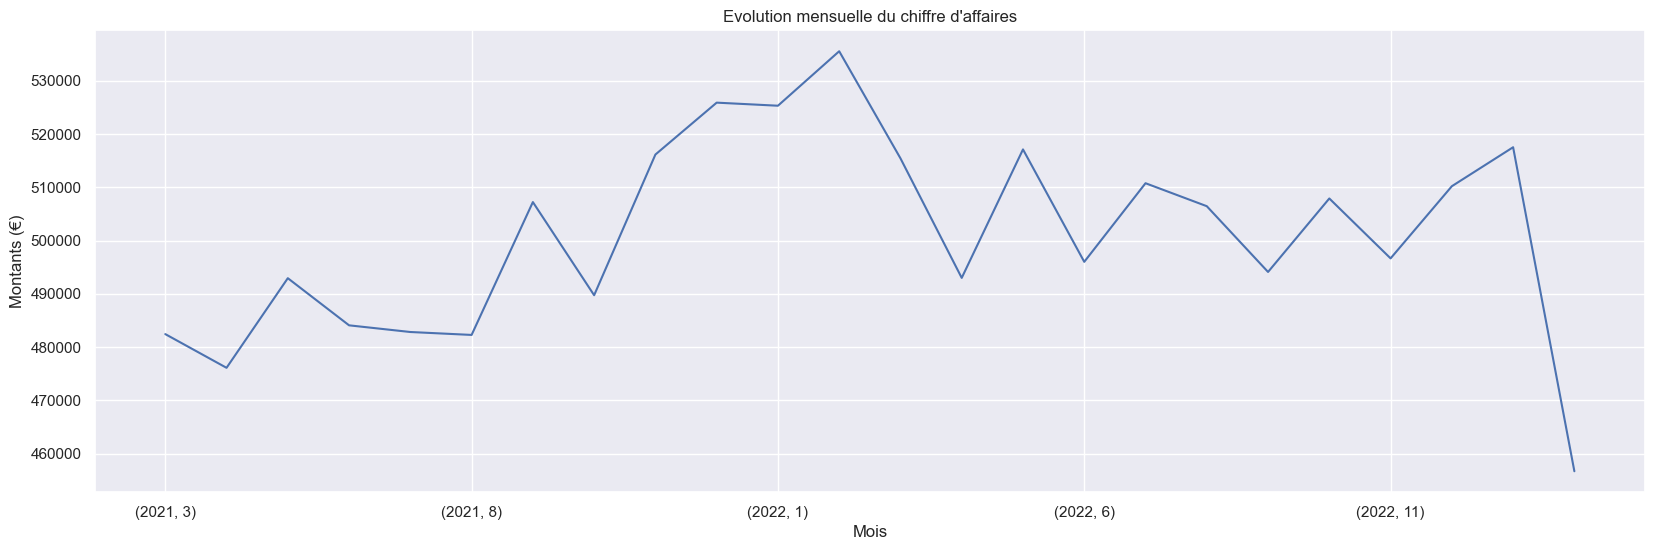

In [296]:
# Representation graphique de l'evolution mensuelle du chiffre d'affaires:
plt.figure(figsize = (20,6))
ca_mensu.plot()
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("Evolution mensuelle du chiffre d'affaires")

Pour voir la tendance globale de l'évolution du chiffre,nous allons lisser au maximum les variations pour faciliter l'interprétation des données et mieux voir les tendances en traçant l'évolution du chiffre d'affaire en moyenne mobile sur 3 mois.

year  month
2021  3                  NaN
      4                  NaN
      5        483831.126667
      6        484380.443333
      7        486622.476667
      8        483069.583333
      9        490786.956667
      10       493089.693333
      11       504384.006667
      12       510609.540000
2022  1        522474.666667
      2        528942.590000
      3        525455.673333
      4        514675.656667
      5        508529.356667
      6        502049.220000
      7        507977.280000
      8        504422.170000
      9        503788.306667
      10       502833.190000
      11       499565.746667
      12       504934.070000
2023  1        508141.663333
      2        494813.270000
Name: price, dtype: float64


Text(0.5, 1.0, "Moyenne mobile du chiffre d'affaire")

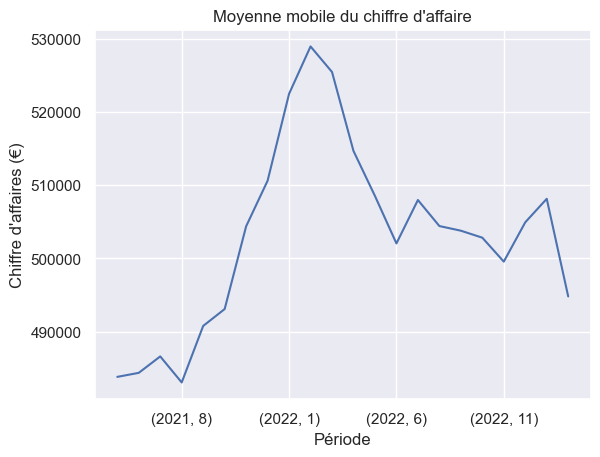

In [297]:
# Decomposition en moyenne mobile:
MovingAverage = ca_mensu.rolling(3).mean()
print(MovingAverage)

# Graphique:
MovingAverage.plot()
plt.xlabel("Période")
plt.ylabel("Chiffre d'affaires (€)")
plt.title("Moyenne mobile du chiffre d'affaire")

## Evolution du chiffre d'affaires par catégories :

**CA par catégorie :**

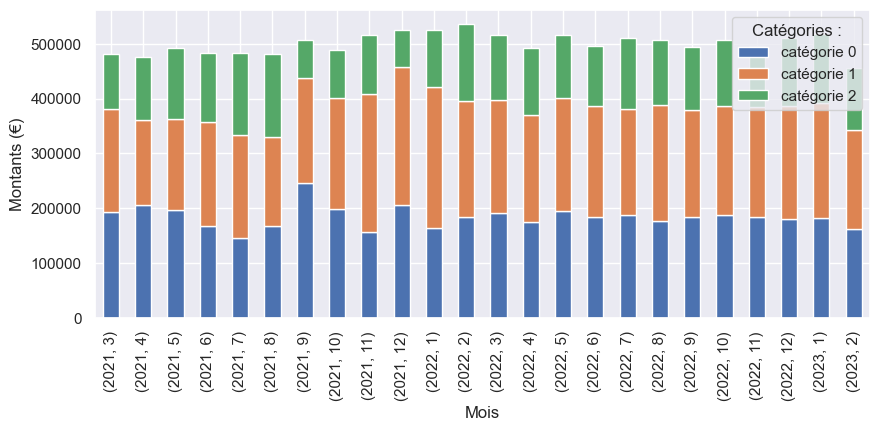

In [298]:
ventes_df.groupby(["year","month","categ"])["price"].sum().unstack().plot.bar(figsize=(10, 4),stacked=True);
plt.legend(["catégorie 0", "catégorie 1", "catégorie 2"],loc='upper right',title='Catégories :')
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.show()

**Conclusion :**

* Le chiffre d'affaire par catégorie suit la même hiérarchie année après année.
* Les trois catégories sont vendues toute au long des trois année.

Pour pousser un peu nous analyses en regarde l'évolution du CA moyen par catégorie par an.

**CA moyen par catégorie :**

In [299]:
CA_categ_moyen = ventes_df.pivot_table(values = ['price'],index=['categ'], columns='year')

CA_categ_moyen

price                      
year        2021       2022       2023
categ                                 
0.0    10.639495  10.637639  10.634535
1.0    20.515060  20.469766  20.505837
2.0    76.286105  76.022330  76.956909

La catégorie 2 est la plus chère sur les trois années ( 76 € )

In [300]:
# Préparation des séries nécessaires pour le graphique

CA_categ_moyen_i = CA_categ_moyen.reset_index() #réinitialiser l'index du DataFrame

CA_categ_moyen_CA = CA_categ_moyen.price

In [2]:
print(CA_categ_moyen_i)

NameError: name 'CA_categ_moyen_i' is not defined

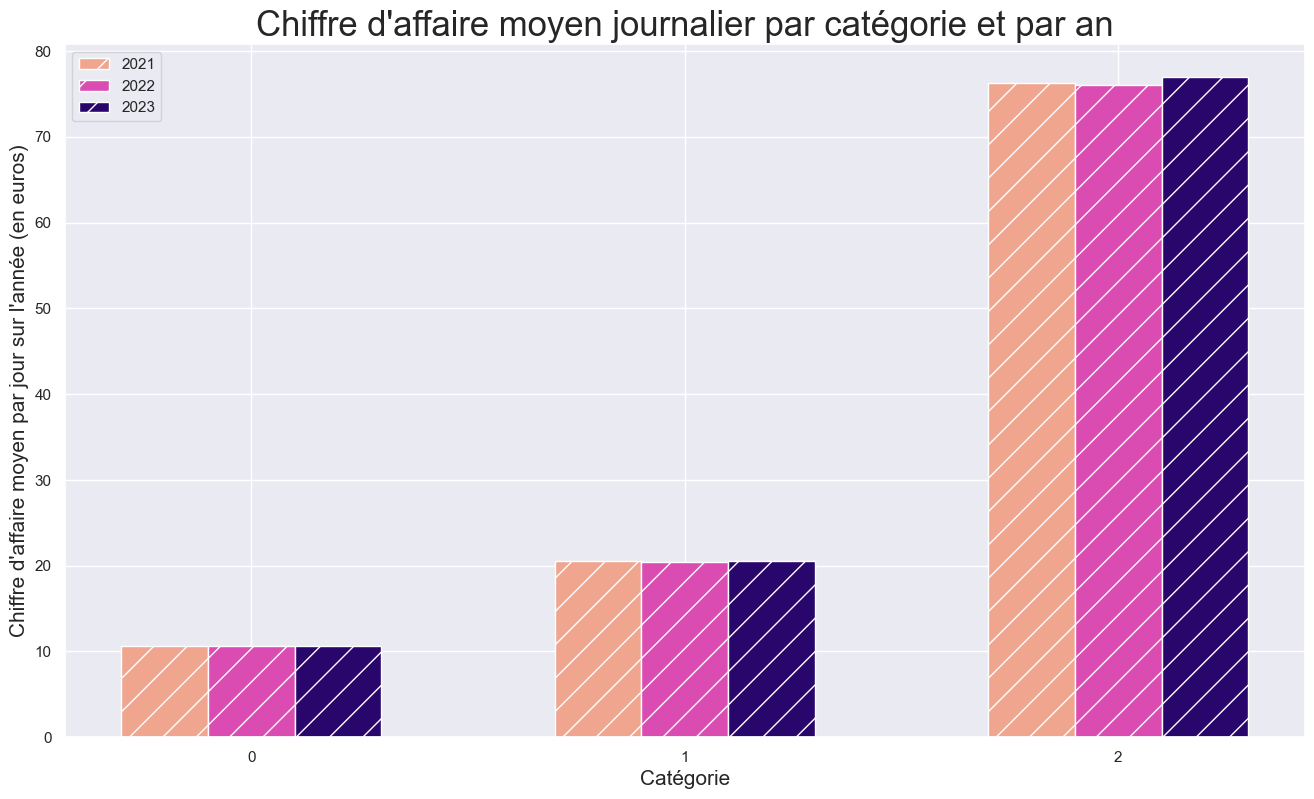

In [301]:
#Graphique du CA moyen par catégorie par an

plt.figure(figsize=(16,9))
w=0.2
x=['0','1','2']
cm_2021 = CA_categ_moyen_CA.iloc[:,0]
cm_2022 = CA_categ_moyen_CA.iloc[:,1]
cm_2023 = CA_categ_moyen_CA.iloc[:,2]

bar1=np.arange(len(x))
bar2=[i+w for i in bar1]
bar3=[i+w for i in bar2]


plt.bar(bar1,cm_2021,w,color="#F0A58F", label="2021", edgecolor="#FFFFFF",hatch= "/")
plt.bar(bar2,cm_2022,w,color="#DB4CB2",  label="2022",hatch= "/")
plt.bar(bar3,cm_2023,w,color="#29066B", label="2023",hatch= "/")
plt.title("Chiffre d'affaire moyen journalier par catégorie et par an", fontsize= 25)
plt.xlabel('Catégorie', fontsize = 15)
plt.ylabel("Chiffre d'affaire moyen par jour sur l'année (en euros)", fontsize = 15)
plt.xticks(bar1+w,x )
plt.legend()
plt.show()

**Conclusion :**
* Peu d'évolution du CA moyen selon les années
* En revanche le CA moyen généré par catégorie diffère très fortement selon les catégories, la catégorie 2 qui générent le plus du CA.

## Analyse ciblée Produits :


### tops & flops : 

Dans cette partie le but est d'analyser les ventes par produits, donc on va regrouper les ventes par références.

On commence par voire la distribution des prix produits et le calcul du prix moyen, médian, modal et l'écart type.

In [302]:
#Calcul de la Moyenne des prix produits vendus 
round(ventes_df['price'].mean(), 2)

17.49

In [303]:
#Calcul de la Mediane des prix produits vendus
ventes_df['price'].median()

13.99

In [304]:
#Calcul du Mode des prix produits vendus
ventes_df['price'].mode()

0    15.99
Name: price, dtype: float64

In [305]:
#Calcul de l'écart type des prix produits vendus 
round(ventes_df['price'].std(ddof=0), 2)

18.24

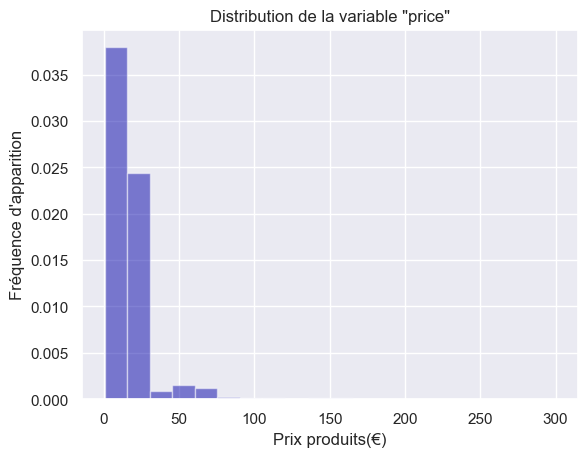

In [306]:
#Visualisation (Histogramme)de la distribution des prix produits
ventes_df['price'].hist(color='#0504aa', alpha=0.5, density=True, bins=20)

plt.title('Distribution de la variable "price"')
plt.xlabel('Prix produits(€)')
plt.ylabel('Fréquence d\'apparition')

plt.savefig("distribution_price.png")
plt.show()

* Les produits <30 euros sont les plus populaires.
* Peu de dispertion des prix

 Nous allons rentré  dans le détail de vente des produits on se focalisent sur les tops et flops produits.

**les tops et les flops produits en fonction des quantités :**

In [307]:
# Nombre de ventes par références
nbr_ventes_ref = ventes_df.groupby(["id_prod"])["session_id"].count()
nbr_ventes_ref

id_prod
0_0       1242
0_1        487
0_10        22
0_100        3
0_1000     432
          ... 
2_95         4
2_96       598
2_97        13
2_98         1
2_99         7
Name: session_id, Length: 3265, dtype: int64

In [308]:
# les tops et les flops produits en fonction des quantités :
print("Références les plus vendues : ")
print(nbr_ventes_ref.nlargest(5))
print("Références les moins vendues : ")
print(nbr_ventes_ref.nsmallest(5))

Références les plus vendues : 
id_prod
1_369    2338
1_417    2267
1_414    2245
1_498    2200
1_425    2162
Name: session_id, dtype: int64
Références les moins vendues : 
id_prod
0_1151    1
0_1284    1
0_1379    1
0_1498    1
0_1539    1
Name: session_id, dtype: int64


Les produits les plus vendus appartiennent à la catégorie 1 tandis que les pires ventes appartiennent à la catégorie 0.

**les tops et les flops produits en fonction du chiffre d\'affaires :**

In [309]:
#les tops et les flops produits en fonction du chiffre d'affaires
CA_ref = ventes_df.groupby(["id_prod"])["price"].sum()
CA_ref
print("Références génèrent le plus de CA : ")
print(CA_ref.nlargest(5))
print("Références génèrent le moins de CA : ")
print(CA_ref.nsmallest(5))

Références génèrent le plus de CA : 
id_prod
2_159    94893.50
2_135    69334.95
2_112    65407.76
2_102    60736.78
2_209    56971.86
Name: price, dtype: float64
Références génèrent le moins de CA : 
id_prod
0_1539    0.99
0_1284    1.38
0_1653    1.98
0_1601    1.99
0_541     1.99
Name: price, dtype: float64


Les produits qui génèrent le plus de chiffre d'affaires ne sont pas les mêmes que ceux qui sont le plus vendus. Les produits vendus en grande quantités ne sont donc pas forcément les plus chers.


### Répartition du CA par produits :

 Voyons comment se répartissent les ventes de chaque catégorie. Pour ce faire, nous allons tracer un camembert qui montre la répartition des ventes par catégories en chiffre d'affaires et en quantité (nombre de ventes). 

**Répartition des ventes par catégories en chiffre d\'affaires :**

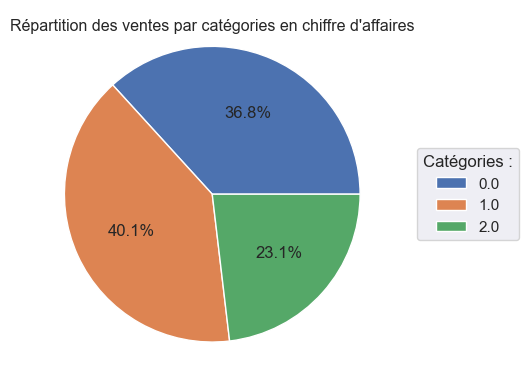

In [310]:
categories = ventes_df['categ'].unique()
ca_categ = ventes_df.groupby('categ')['price'].sum()
fig, ax = plt.subplots()
plt.pie(ca_categ, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
plt.title('Répartition des ventes par catégories en chiffre d\'affaires', y=0.92, size=11.5)
fig.legend(categories, title='Catégories :', loc='right')
plt.show()


Les deux catégories "0" et "1" génèrent un chiffre d'affaires comparable tandis que la catégorie "2" génère le mois du chiffre d'affaires. Voyons maintenant la répartition par quantité de produits vendus.

**Répartition des ventes par catégories en quantité :**

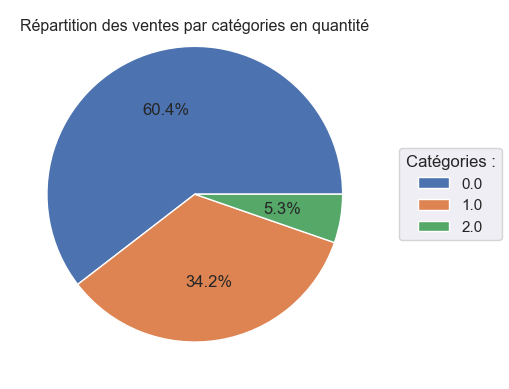

In [311]:
categories = ventes_df['categ'].unique()
quant_categ = ventes_df.groupby('categ')['session_id'].count()
fig, ax = plt.subplots()
plt.pie(quant_categ, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
plt.title('Répartition des ventes par catégories en quantité', y=0.92, size=11.5)
fig.legend(categories, title='Catégories :', loc='right')
plt.show()

* Plus de 60% des ventes se font sur les produits de la catégorie 0, mais ceux de la catégorie 2 représentent seulement 5% des ventes. Pourquoi ??
* La répartition des quantités est par contre très inégale. Il apparaît donc que les prix des produits des différentes catégories sont très inégaux.


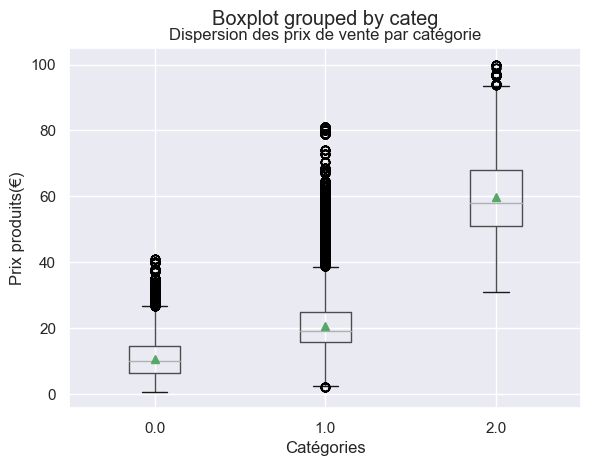

In [312]:
#Comparaison de distribution des prix produits par catégorie avec un boxplot
subset = ventes_df[ventes_df.price < 100]
subset.boxplot(column='price', by='categ', showmeans=True)

plt.title('Dispersion des prix de vente par catégorie')
plt.xlabel('Catégories')
plt.ylabel('Prix produits(€)')

plt.savefig("dispersion_categories.png")
plt.show()

C'est certainement du au prix plus élévé des produits de la catégorie 2.

Maintenant, on cherche à avoir la courbe de Lorenz sur les produits


**Courbe de Lorentz: (Repartition du CA par produits) :**

indice de Gini: 0.695


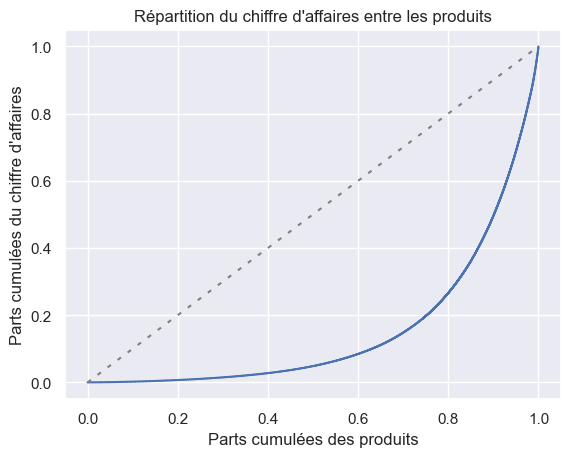

In [313]:
# Courbe de Lorentz: (Repartition du CA par produits)
lorenz_CA_prod = np.cumsum(np.sort(nbr_ventes_ref)) / nbr_ventes_ref.sum()
lorenz_CA_prod = np.append([0], lorenz_CA_prod)
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), lorenz_CA_prod, drawstyle='steps-post'),
plt.plot(np.linspace(0,1,len(lorenz_CA_prod)), np.linspace(0,1,len(lorenz_CA_prod)),color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des produits")
plt.title("Répartition du chiffre d'affaires entre les produits")
aire_ss_courbe_CA_prod = lorenz_CA_prod[:-1].sum() / len(lorenz_CA_prod)
S_ca_prod = 0.5 - aire_ss_courbe_CA_prod
gini_CA_prod = 2* S_ca_prod
print("indice de Gini:",round(gini_CA_prod,3))


**Conclusion :**
* On peut voir que la répartition du CA par produit est plus inégalitaire.
* 80% des produits ne détient que 30% du CA.
* L'indice de Gini s'éloigne fortement de 0, le poids des produits dans le chiffre d'affaires global est donc très inégal.


# Analyse ciblée les clients : analyse du comportement client

## Profils clients :


In [314]:
# Meilleurs clients:
best_client = ventes_df.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609    326039.89
c_4958    290227.03
c_6714    153918.60
c_3454    114110.57
c_1570      5285.82
c_3263      5276.87
c_2140      5260.18
c_2899      5214.05
c_7319      5155.77
c_7959      5135.75
Name: price, dtype: float64


**Remarque importante :**
* Les quatres premiers clients qui génèrent le plus de CA par rapport aux autres clients. Ils peut s'agir des revendeurs (libraires, bibliothécaires). Il est possible de proposer un accompagnement presonnalisé à ces clients puisqu'ils n'auront pas les mêmes besoins que des particuliers.

In [315]:
# Nombre moyen d'achats par sessions:
print("Il y a eu",
      ventes_df["session_id"].nunique(),
      "sessions")

print("Une session aboutie en moyenne à",
      round(ventes_df.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),
      "achats")

Il y a eu 345387 sessions
Une session aboutie en moyenne à 1.99 achats



=> Il y a **342 315** sessions pour un total de **687 298** transactions, il est donc courant d'avoir plusieurs transactions par sessions. En moyenne une session aboutie sur **1,99** achats.

On cherche maintenant à sortir une courbe de Lorenz ainsi qu'un coefficient de gini afin de mesurer l'inégalité de repartition du CA entre les clients


**Courbe de Lorentz: (repartition du CA par clients) :**


indice de Gini: 0.442


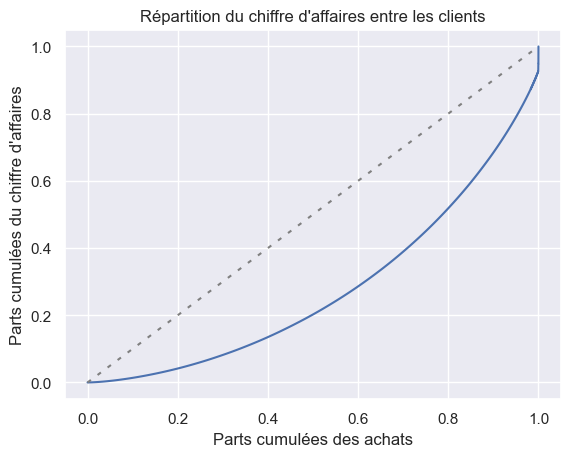

In [316]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

**Conclusion :**

 On peut voir que la répartition du CA par client est relativement équitable. Indice de gini à 0.44 qui témoigne d'une répartition du CA plutot homogène sans être strictement égalitaire.


## Repartition du genre parmis nos clients:


sex
f    4490
m    4131
Name: client_id, dtype: int64


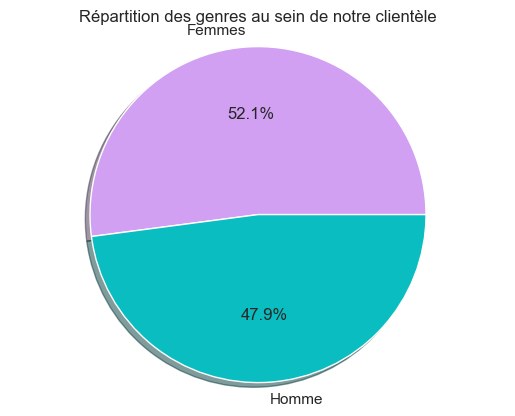

In [317]:
# Repartition des genres parmis nos clients:
repartition_genre = customers_df.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

## Depenses par genres:

montant total des achats par genre:
 sex
f    5948066.84
m    6074606.71
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    342564
m    344734
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f    17.363374
m    17.621142
Name: price, dtype: float64


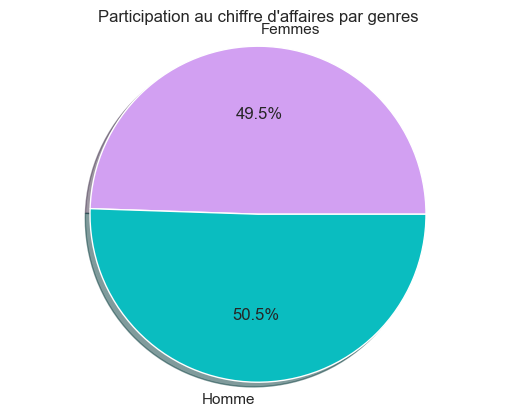

In [318]:
# Depenses par genres:
repartition_achats_genre = ventes_df.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = ventes_df.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = ventes_df.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
fig3, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["#d2a0f2","#0abdc0"],
        shadow=True)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres")
plt.show()

#  Analyse des correlations entre les variables


Dans cettes partie du projet, on s\' intéressent à étudier les corrélations indiquent si deux variables sont linéairement équivalentes.

Ceci ce fait via les questions suivantes pour nous aider à mieux comprendre les ventes enregistrées.

* Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
* Y a-t-il une corrélation entre l\'âge des clients et le montant total des achats ?
* Y a-t-il une corrélation entre l\'âge des clients et la fréquence d’achat (nombre d'achats par mois) ?
* Y a-t-il une corrélation entre l\'âge des clients et la taille du panier moyen ?
* Y a-t-il une corrélation entre l\'âge des clients et les catégories de produits achetés ?

## Lien entre le genre et la catégorie de livres


Dans le but est d'évaluer la relation entre les deux variables 'genre' et ' catégorie de livres' (dépendance ou bien indépendance), je choisis comme test statistique : le test du chi2.



**Vérifications des conditions d'application du test du chi2 :**
* Type de variables : ce test est préconisé pour évaluer la dépendance entre deux variables catégorielles qualitatives comme c'est ici le cas.
* Indépendance des observations:  les valeurs observées pour chaque variable ne sont pas influencées par les valeurs observées pour l'autre variable.
* Taille de l'échantillon: les échantillons doivent être suffisamment grands (687298 transactions)
* Pour chaque case du tableau de contingence , les effectifs attendues sont supérieurs à 5 ( A vérifier aprés avoir construit le tableau)


**Les hypothèses:**
* On pose H0, l'hypothèse nulle d'indépendance des variables
* On pose H1, l'hypothèse alternative de dépendances des variables
* Pour un risque de 5% :

Si la p-value obtenue est inférieure à 0.5 on peut alors rejeter l'hypothèse nulle.


* Je commence par produire le tableau de contingence qui fournit les effectifs de vente selon le sexe et la catégorie
* Je génère ensuite le test
* Je calcule le coefficient de Cramer pour mesurer la force de l'association entre le genre et la catégorie produit (des valeurs plus proches de 1 indiquant une association plus forte).

**Tableau de contingence :**


In [319]:
# Table de contingence pour Chi²:
categ_sex = pd.crosstab(ventes_df["sex"],ventes_df["categ"])
print(categ_sex)

categ     0.0     1.0    2.0
sex                         
f      206103  119178  17283
m      209356  116178  19200


**Remarque :**
Pour chaque case du tableau de contingence , les effectifs attendues sont supérieurs à 5.


**Test Chi 2 :**


In [320]:
# Chi²:
chi2, p_value, ddl, Expected_freq = chi2_contingency(categ_sex)

print("Les fréquences théoriques sont:\n", Expected_freq,3)
print(f"Ce qui donne un X² de {chi2:.3f} à", ddl, "ddl")
print(f"soit une p-value de", p_value)

# Calcul du coefficient de Cramer:
n = len(ventes_df)
minDim = min(categ_sex.shape)-1

V = np.sqrt((chi2/n) / minDim)

print("Le V de Cramer vaux:", V)

Les fréquences théoriques sont:
 [[207073.63745566 117306.4562737   18183.90627064]
 [208385.36254434 118049.5437263   18299.09372936]] 3
Ce qui donne un X² de 157.590 à 2 ddl
soit une p-value de 6.023430519385375e-35
Le V de Cramer vaux: 0.015142280789843969


**Conclusion :**
* Avec une p_value aussi faible(<0.05), on peut rejetter H0 et accepter H1
* On peut considérer sans trop de risques (au risque de 5%) que les variable catégorie et sexe sont dépendantes.
* Le coefficient de Cramer proche de zéro indique une faible association entre les deux variables.

## Analyse de la corrélation entre l'âge clients et le montant total des achats



 **Repartition des ages parmis nos clients :**


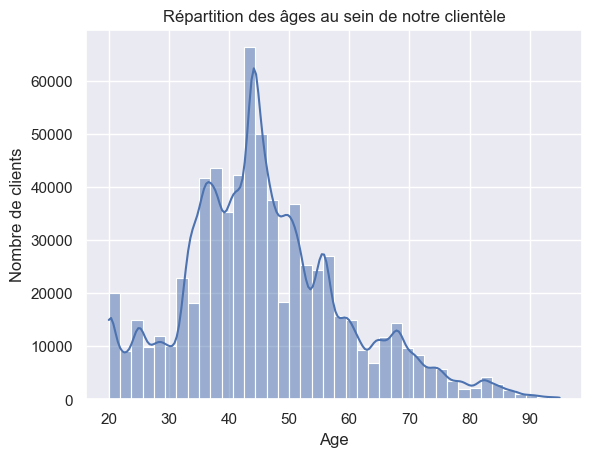

In [321]:
# Repartition des ages parmis nos clients:
sns.histplot(data=ventes_df["age"],
             bins=40,
             kde=True)
plt.title("Répartition des âges au sein de notre clientèle")
plt.ylabel("Nombre de clients")
plt.xlabel("Age")
plt.show()

**Lien entre l'age et le montant des achats :**


* L'age et le chiffre d'affaires sont deux variables quantitatives
* Un lien entres ces deux variables peut être visualisé gràce à un nuage de points pour avoir une idée sur la distribution.
* Je procède dans un premier temps à la création d'un nuage de points pour identifier un éventuel lien.
* j'effectue un test de spearman pour vérifier le lien entre mes variables.

In [322]:
# Lien entre l'age et le montant des achats:
age = ventes_df.groupby(["age"])["client_id"].count()
tot_achats_age = ventes_df.groupby(["age"])["price"].sum()
print("age Vs nombre de clients \n", age)
print("age Vs Montant en € \n", tot_achats_age)

age Vs nombre de clients 
 age
20.0    15495
21.0     4491
22.0     4709
23.0     4369
24.0     4522
        ...  
91.0      336
92.0      312
93.0      170
94.0      238
95.0      202
Name: client_id, Length: 76, dtype: int64
age Vs Montant en € 
 age
20.0    616363.62
21.0    180680.89
22.0    186749.27
23.0    181011.64
24.0    167239.80
          ...    
91.0      5477.83
92.0      5059.18
93.0      2815.45
94.0      4251.22
95.0      3249.84
Name: price, Length: 76, dtype: float64


Text(0.5, 1.0, 'Motant des achats par âges')

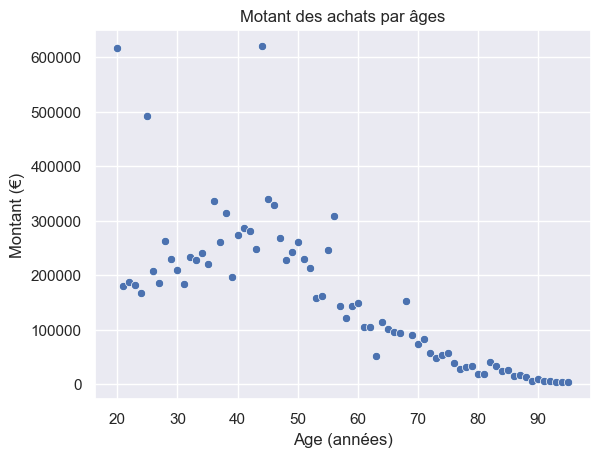

In [323]:
# Graphique: Visualisation avec un scatterplot (âge clients vs montant total des achats)
sns.scatterplot(data= tot_achats_age)
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Motant des achats par âges")

Les ages ne suivent pas une distribution Normale, le test est forcément non pramétrique, on utilise donc un test de corrélation de Spearman.



**Test de Spearman :**

Ce test dit non paramétrique est ici plus adapté dans la mesure où la distribution n'est pas normale. Il est utilisé pour évaluer la corrélation monotone entre deux variables. Contrairement au test de corrélation de Pearson, qui évalue la corrélation linéaire entre deux variables continues, le test de Spearman évalue la corrélation entre les rangs des observations, ce qui le rend approprié pour les variables non normalement distribuées.

**Interprétez le résultat d'une corrélation de Spearman :**

Lorsque vous interprétez le résultat d'une corrélation de Spearman, vous devez tenir compte de la valeur de la statistique de corrélation de Spearman (généralement notée ρ) ainsi que de la valeur p associée au test

**Statistique de corrélation de Spearman (ρ) :**

* La statistique de corrélation de Spearman mesure la force et la direction de la relation monotone entre les variables.
* La valeur de ρ peut varier de -1 à 1.
* Une valeur de ρ proche de 1 indique une corrélation positive forte (c'est-à-dire que les valeurs élevées d'une variable sont associées à des valeurs élevées de l'autre variable et vice versa).
* Une valeur de ρ proche de -1 indique une corrélation négative forte (c'est-à-dire que les valeurs élevées d'une variable sont associées à des valeurs faibles de l'autre variable et vice versa).
* Une valeur de ρ proche de zéro indique une faible corrélation ou l'absence de corrélation monotone entre les variables.

**Valeur p :**

* La valeur p associée au test de Spearman mesure la probabilité d'observer les données si l'hypothèse nulle (pas de corrélation monotone) est vraie.
* Une valeur p faible (généralement < 0,05) indique que les données fournissent des preuves suffisantes pour rejeter l'hypothèse nulle au profit de l'hypothèse alternative (il y a une corrélation monotone significative entre les variables).
* Une valeur p élevée suggère qu'il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle.

**Les hypothèses :**
* Hypothèse nulle (H0) : Il n'y a pas de corrélation entre les deux variables age et montant total des achats.
* Hypothèse alternative (H1) : Il y a une corrélation  entre les deux variables.

In [324]:
# Correlation entre l'age et le montant total des achats:
print("Corrélation de Speraman:", st.spearmanr(tot_achats_age.index,tot_achats_age.values))

Corrélation de Speraman: SignificanceResult(statistic=-0.8580177717019822, pvalue=4.147997358922491e-23)


**Conclusion :**

Le coefficient est négatif par conséquent, on peut émettre l'hypothèse que plus les consommateurs sont agés plus le montant total de leur achat est faible. Or le coefficient est plus proche de -1 que de zéro. Par conséquent, on peut affirmer que plus la tranche d'age augmente plus le chiffre d'affaires baisse.(**forte correlation négative**)

**Remarque :**
Pour la suite de nous analyses, nous allons opter pour supprimer les quatres premiers clients "revendeurs" (outliers) qui générent le plus de chiffre d'affaires, pour éviter de fausser nos analyses.

In [325]:
ventes_df.drop(ventes_df[(ventes_df["client_id"] == "c_1609") | (ventes_df["client_id"]=='c_4958') | 
                         (ventes_df["client_id"]=='c_6714') |  (ventes_df["client_id"]=='c_3454') ].index, inplace=True)

## Analyse de la corrélation entre l'âge clients et la fréquence d'achat


Ici la fréquence d'achat correspond au nombre d'achats par mois.



* Je commence par créer un nouveau df comprenant la fréquence d'achat
* J'ai deux variables quantitative, je produits un test de correlation de pearson si distribution normale sinon un test de spearman.

**Calcul de la fréquence d'achat :**


In [326]:
ventes_df.groupby(["client_id", "year", "month"])["session_id"].nunique()

client_id  year  month
c_1        2021  6        1
                 7        4
                 8        1
                 9        2
                 10       2
                         ..
c_999      2022  10       1
                 11       2
                 12       1
           2023  1        4
                 2        1
Name: session_id, Length: 138101, dtype: int64

In [327]:
freq_mensu= ventes_df.groupby(["client_id", "year", "month"])["session_id"].nunique().groupby(["client_id"]).mean().reset_index()


#Rq: changer nom session_id par freq_m dans df freq_mensu
freq_mensu. rename(columns={'session_id': 'freq_mensu'}, inplace= True)

freq_mensu

,client_id,freq_mensu
0,c_1,2.000000
1,c_10,2.125000
2,c_100,1.000000
3,c_1000,4.272727
4,c_1001,2.350000
...,...,...
8591,c_995,1.125000
8592,c_996,3.478261
8593,c_997,1.263158
8594,c_998,1.600000


In [328]:
# Ajout des ages au df frequence mensuelle:
freq_mensu = pd.merge(customers_df, freq_mensu, on="client_id",how="outer")
freq_mensu = freq_mensu.dropna()                                                #On enleve les clients non acheteurs

freq_mensu

,client_id,sex,birth,age,freq_mensu
0,c_4410,f,1967,57,2.476190
1,c_7839,f,1975,49,1.666667
2,c_1699,f,1984,40,1.000000
3,c_5961,f,1962,62,2.416667
4,c_5320,m,1943,81,1.384615
...,...,...,...,...,...
8616,c_7920,m,1956,68,2.400000
8617,c_7403,f,1970,54,5.347826
8618,c_5119,m,1974,50,1.562500
8619,c_5643,f,1968,56,3.958333


In [329]:
# Lien entre l'age et la frequence d'achat mensuelle:
freq_age = freq_mensu.groupby(["age"], as_index = False)["freq_mensu"].mean()

print(freq_age)

    age  freq_mensu
0    20    1.454276
1    21    1.421213
2    22    1.404476
3    23    1.460211
4    24    1.423597
..  ...         ...
71   91    1.892592
72   92    1.902536
73   93    1.652614
74   94    2.111801
75   95    2.160948

[76 rows x 2 columns]


**Visualisation avec un scatterplot (âge client vs fréquence d'achat mensuelle) :**


Text(0.5, 1.0, "Fréquence mensuelle d'achat par âge")

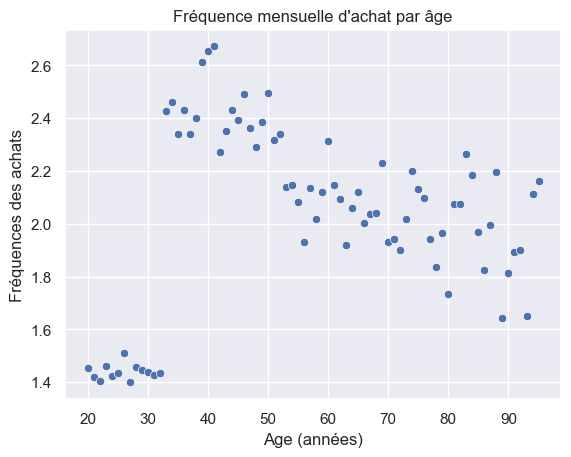

In [330]:
# Graphique
sns.scatterplot(x=freq_age['age'], y=freq_age['freq_mensu'])
plt.ylabel("Fréquences des achats")
plt.xlabel("Age (années)")
plt.title("Fréquence mensuelle d'achat par âge")

 Ce nuage de points montre une tendance  à la baisse du fréquence d'achats avec l'âge avec des clients dont l'age entre 20 et 30 ans qui se démarquent du reste des clients avec un nombre d'achats faible (entre 1.4 et 1.5).

 La distribution des variables ne semble pas suivre une loi normale donc on passe au test de Spearman.

**Les hypothèses :**
* Hypothèse nulle (H0) : les deux variables sont indépendantes et qu'il n'y a pas de corrélation entre elles.

* Hypothèse alternative (H1) : les deux variables ne sont pas indépendantes et qu'il existe une corrélation entre elles.

**Calcul du coefficient de corrélation de Spearman :**


In [331]:
# Correlation entre l'age et le montant total des achats
print("Corrélation de Spearman:", st.spearmanr(freq_mensu["age"], freq_mensu["freq_mensu"]))

Corrélation de Spearman: SignificanceResult(statistic=0.2041015650722228, pvalue=1.6541857614222247e-81)


**Conclusion :**

Le résultat de spearman induit une légère correlation entre l'age et la fréquence d'achat.


## Analyse de la corrélation entre l'âge clients et le panier moyen


Ici le panier moyen est le montant moyen dépensé par client.

**Calcul du panier moyen :**

In [332]:
#Calcul des depenses totales par clients
total_depenses = ventes_df.groupby('client_id')['price'].sum().reset_index()
total_depenses.sort_values(by = 'price', ascending = True, inplace = True)
total_depenses.rename(columns = {'price':'total_depense'}, inplace = True)
total_depenses

,client_id,total_depense
8147,c_8351,6.31
7914,c_8140,8.30
7885,c_8114,9.98
4042,c_4648,11.20
3853,c_4478,13.36
...,...,...
7002,c_7319,5155.77
2107,c_2899,5214.05
1267,c_2140,5260.18
2512,c_3263,5276.87


In [333]:
# ajout de la colonne age au dataframe total_depenses
depenses_age = total_depenses.merge(customers_df, on = 'client_id', how = 'inner')
depenses_age

,client_id,total_depense,sex,birth,age
0,c_8351,6.31,f,1968,56
1,c_8140,8.30,m,1971,53
2,c_8114,9.98,m,1962,62
3,c_4648,11.20,m,2004,20
4,c_4478,13.36,f,1970,54
...,...,...,...,...,...
8591,c_7319,5155.77,f,1974,50
8592,c_2899,5214.05,f,1994,30
8593,c_2140,5260.18,f,1977,47
8594,c_3263,5276.87,f,1985,39


In [334]:
#création du df contenant le panier moyen  par age
panierMoyen = depenses_age.groupby('age')['total_depense'].mean().reset_index()
panierMoyen.rename(columns = {'total_depense':'panier_moyen'}, inplace = True)
panierMoyen

,age,panier_moyen
0,20,1410.443066
1,21,1246.075103
2,22,1287.926000
3,23,1448.093120
4,24,1229.704412
...,...,...
71,91,684.728750
72,92,843.196667
73,93,703.862500
74,94,1062.805000


**Visualisation avec un scatterplot (âge client vs panier moyen) :**


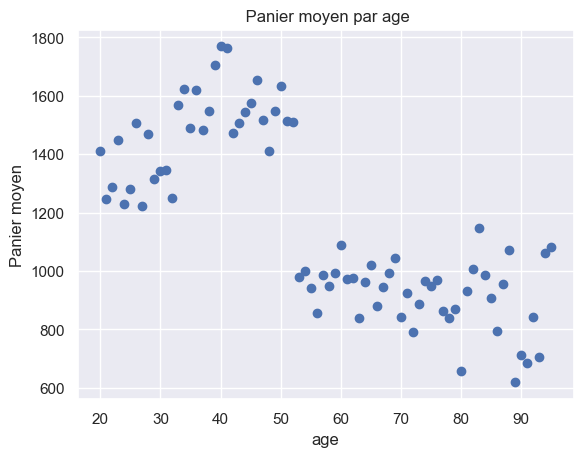

In [335]:
#Visualisation avec un scatterplot 
Y = panierMoyen['panier_moyen']
X = panierMoyen[['age']]
plt.plot(X,Y, "o")
plt.xlabel("age")
plt.ylabel("Panier moyen")
plt.title(' Panier moyen par age')
plt.show()

 La distribution des variables ne semble pas suivre une loi normale donc on passe au test de Spearman.

**Les hypothèses :**
* Hypothèse nulle (H0) : L'hypothèse nulle du test de Spearman est que les deux variables sont indépendantes et qu'il n'y a pas de corrélation entre elles.

* Hypothèse alternative (H1) : L'hypothèse alternative est que les deux variables ne sont pas indépendantes et qu'il existe une corrélation entre elles.

In [336]:
# Correlation entre l'age et le panier moyen : coefficient de corrélation de Spearman

print("Corrélation de Speraman:", st.spearmanr(panierMoyen["age"], panierMoyen["panier_moyen"]))


Corrélation de Speraman: SignificanceResult(statistic=-0.7274367737525631, pvalue=9.891970162274518e-14)


La statistique de corrélation de Spearman (ρ) vaut -0.72 plus proche de -1. Donc, on peut dire qu\'il y a une forte corrélation négative entre l\'age et le prix du panier moyen.

**Conclusion :**

Le test de corrélation démontre un certain lien entre l'âge du client et le panier moyen. Par exemple, sur les individus de plus de 53 ans, le panier moyen reste faible. Il existe également un lien sur les individus de 20 à 50 ans.

## Analyse de la corrélation entre l'âge clients et la catégorie produits


Dans cette partie, on se procédera à déterminer si il y a une relation entre l'age et la catégorie des produits. Donc :
* Je cherche l'influence de la catégorie sur l'age client.
* Je commence par visualiser mes variables avec une boite à moustaches pour visualiser l'influence de la catégorie sur l'age.
* J'ai une variable qualitative (catégorie) et une variable quantitative (age)
* Un test Anova semble alors pertinent dans ce cas. Cependant, il fallait s'assurer de notre choix du test Anova.

**Visualisation des variables avec une boite à moustaches :**


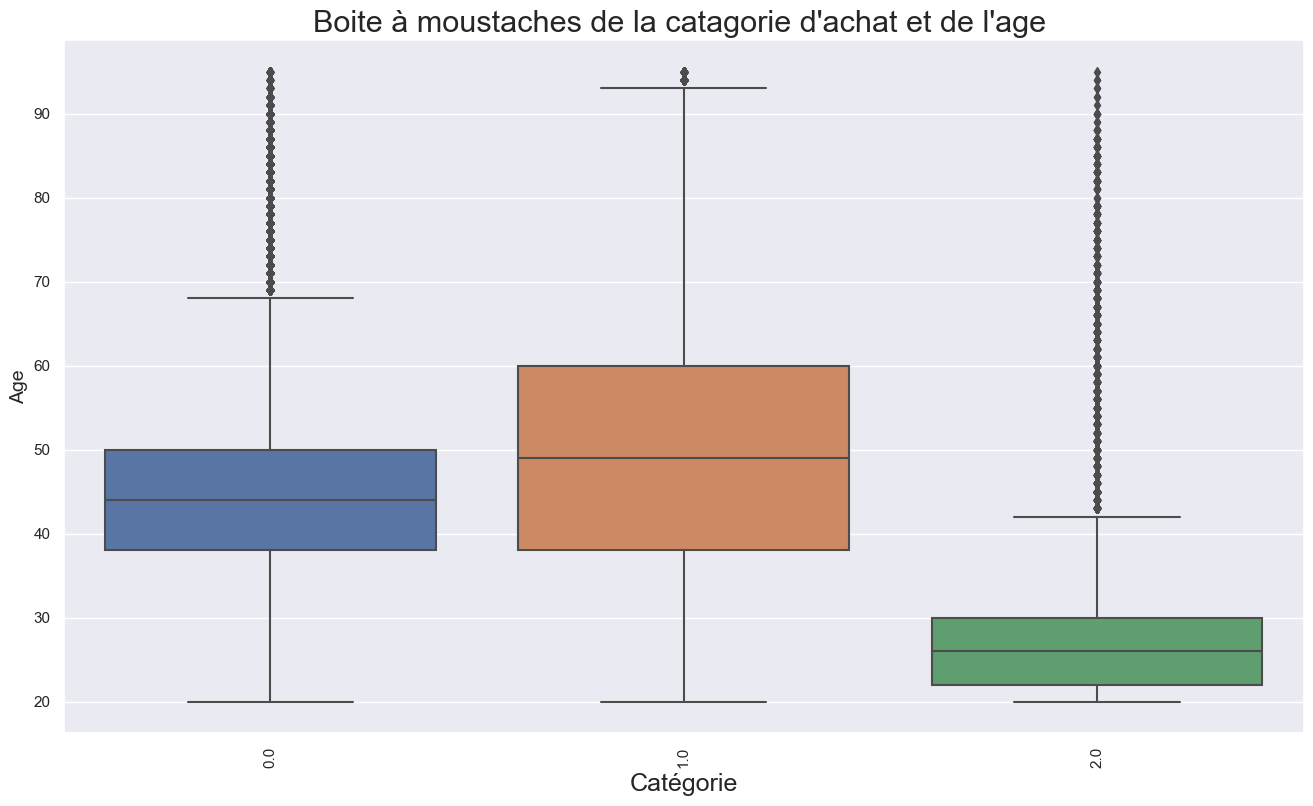

In [337]:
# visualiser mes variables avec une boite à moustaches
plt.figure(figsize=(16,9))
sns.boxplot(data=ventes_df, x="categ", y='age')

plt.title("Boite à moustaches de la catagorie d'achat et de l'age ", fontsize= 22)
plt.xlabel("Catégorie", fontsize = 18)
plt.ylabel("Age", fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

* Les individus qui achetent les produits de la catégorie 0 ont un age médian de 41 ans
* Les individus qui achetent les produits de la catégorie 1 ont un age médian de 48 ans
* Les individus qui achetent les produits de la catégorie 2 ont un age médian de 23 ans

 => Cela explique également pourquoi les jeunes ont un panier moyen plus elevé dans la mesure où il a été montré que la catégorie 2 rassemble des produit dont le prix moyen est significativement plus élevé que ceux des autres catégories

**Vérifications des conditions d'application de l'ANOVA :**

Rappel des conditions de l'ANOVA :
* Indépendance : il n'y a pas de relations cachées entre les observations.

* Normalité : Les données doivent suivre une distribution normale. 

* Homogénéité de la variance : les variances des données sont similaires dans chaque groupe.

=> Pour pouvoir effectuer mes tests facilement, je prend le DataFrame ventes_df qui contient les données sur les ventes, j'extraits les catégories uniques de produits, puis je crée un dictionnaire où chaque catégorie de produits est associée à une liste des âges des clients ayant acheté des produits de cette catégorie.

In [338]:
categ = ventes_df["categ"].unique()
categ_age = {categ: ventes_df.loc[ventes_df["categ"]==categ, "age"] for categ in categ}
#categ_age

=> Avant d'appliquer le test ANOVA nous vérifions tout d'abord les conditions d'application du test. On commence par l'homogénéité des variences puis la normalité de la distribution. La normalité qu'elle fallait vérifier par un test de Shapiro-Wilk et l'homogénéité par un test de  Bartlett. Si toutes les conditions sont valables on applique le test Anova, dans le cas contraire on applique le Kuskral Wallis plus adapté dans le cas de violation des conditions d'ANOVA.

**Test de Bartlett : pour l'homogénéité de la variance** 

**Les hypothèses du test :**
* Hypothèse nulle (H0) : les variances des échantillons dans chaque groupe sont égales.
* Hypothèse alternative (H1) : les variances des échantillons dans au moins un groupe sont différentes.

In [339]:
from scipy.stats import bartlett

# Application du test de Bartlett
statistique, p_value = bartlett(categ_age[0], categ_age[1], categ_age[2])

# Affichage des résultats
print("Statistique de test de Bartlett :", statistique)
print("Valeur p :", p_value)

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Les variances ne sont pas égales (rejet de l'hypothèse nulle)")
else:
    print("Les variances sont égales (absence de preuves pour rejeter l'hypothèse nulle)")

Statistique de test de Bartlett : 34052.53406937691
Valeur p : 0.0
Les variances ne sont pas égales (rejet de l'hypothèse nulle)


**Test Shapiro-Wilk : pour la normalité**

In [340]:
pivot_age_categ0 = ventes_df.pivot_table(['categ'], index = ['age'])

# Test de Shapiro-Wilk
statistic, p_value = st.shapiro(pivot_age_categ0)

# Affichage des résultats
print("Statistique de test :", statistic)
print("Valeur p :", p_value)

# Interprétation
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale.")
else:
    print("Les données ne suivent pas une distribution normale. On applique le test de Kruskal Wallis.")

Statistique de test : 0.800857424736023
Valeur p : 9.452763016781773e-09
Les données ne suivent pas une distribution normale. On applique le test de Kruskal Wallis.


Une violation des deux conditions d'homogénéité et égalité entre les variences des groupes, il est préférable de ne pas utiliser l'ANOVA. Dans ce cas, on utilise Kruskal Wallis une alternative robuste à l'ANOVA  qui ne nécessite pas l'hypothèse d'homogénéité des variances ni celle de normalité des données.

**Test de Kruskal Wallis :**

Le test de Kruskal-Wallis est un test non paramétrique utilisé pour déterminer s'il existe des différences significatives entre les médianes de trois groupes ou plus. Il est utilisé comme alternative à l'ANOVA lorsque les données ne satisfont pas aux conditions d'application de l'ANOVA, telles que la normalité.

**Les hypothéses du test :**
* L’hypothèse nulle Ho : toutes les categories sont vendues de manière similaire selon la catégorie d'age
* L’hypothèse alternative H1 : L'une des catégorie se vend plus ou moins selon l'age.

In [99]:
# Lien entre age et categorie achetees: Kruskal Wallis 
print(st.kruskal(categ_age[0], categ_age[1], categ_age[2]))

KruskalResult(statistic=71374.94615497025, pvalue=0.0)


**Conclusion :**

* p-val < 0,05, on peut ici rejeter aisément H0 et conclure que l'age influe sur le choix d'acheter une catégorie plutot qu'une autre.

**En conclusion**

Il serait interessant de pousser l'analyse sur d'autres aspects comme celui de collecter dans notre pipeline la durée des sessions, plus d'informations sur les clients (catégorie socio-professionnelle, zone géographique, date de création de compte), sur les produits (catégories plus détaillées, date de sortie de l'ouvrage). Il faudrait également comparer le comportement en ligne et hors ligne, en particulier pour les clients utilisant les deux modes d'achats.